In [1]:
import torch
import wandb
from hydra import compose, initialize

from dviforbml.evaluation.visualization.visualize_dvinp import visualize_dvinp
from dviforbml.evaluation.visualization.visualize_task import visualize_task
from dviforbml.utils.helper import download_run, get_name_dvinp
from dviforbml.utils.load_dvinp import load_dvinp

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
try:
    import torch_directml

    device = torch_directml.device()
except ImportError:
    device = torch.device("cpu")

device = torch.device("cpu")

In [4]:
# project = "cluster-dvinp-linesine"
# name = "16-None-mean-cos-dis-True-cntxt"  # "16-1-bca-free-dis-True-False-context-1.0-0"
# dir = download_run(project, name)

dir = "../models/dvinp"

In [5]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    model, trainer, test_loader, _ = load_dvinp(
        cfg=cfg,
        device=device,
        dir=dir,
        load_decoder_only=False,
        train_decoder=True,
        debugging=True,
    )


Generating tasks: 100%|██████████| 2/2 [00:00<00:00, 16946.68it/s]


model not found at ../models/dvinp/model.pth
optim not found at ../models/dvinp/optim.pth


In [6]:
# torch.save(model.decoder.state_dict(), f"{dir}/decoder.pth")

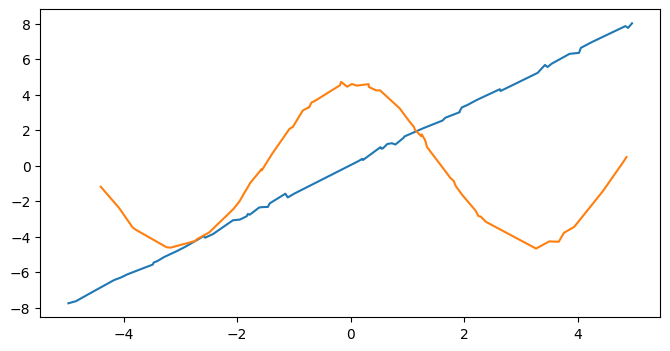

In [7]:
visualize_task(test_loader)

In [8]:
trainer.wandb_logging = True
if trainer.wandb_logging:
    wandb.init(project="2-tasks", name=get_name_dvinp(cfg))

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [15]:
model.freeze_decoder()

train = True

if train:
    trainer.optimizer.param_groups[0]["lr"] = 0.1 * cfg.training.learning_rate
    # print(trainer.optimizer.param_groups[0]["lr"])

    num_epochs = 500
    losses = trainer.train(
        num_epochs=num_epochs,
        max_clip_norm=cfg.training.max_clip_norm,
        alpha=None,
        validate=False,
    )

    # torch.save(dvinp.state_dict(), f"{dir}/dvinp.pth")

100%|██████████| 1/1 [00:00<00:00,  6.64it/s, epoch=499, loss=22.8, lmpl=-37.4, mse=2.04]


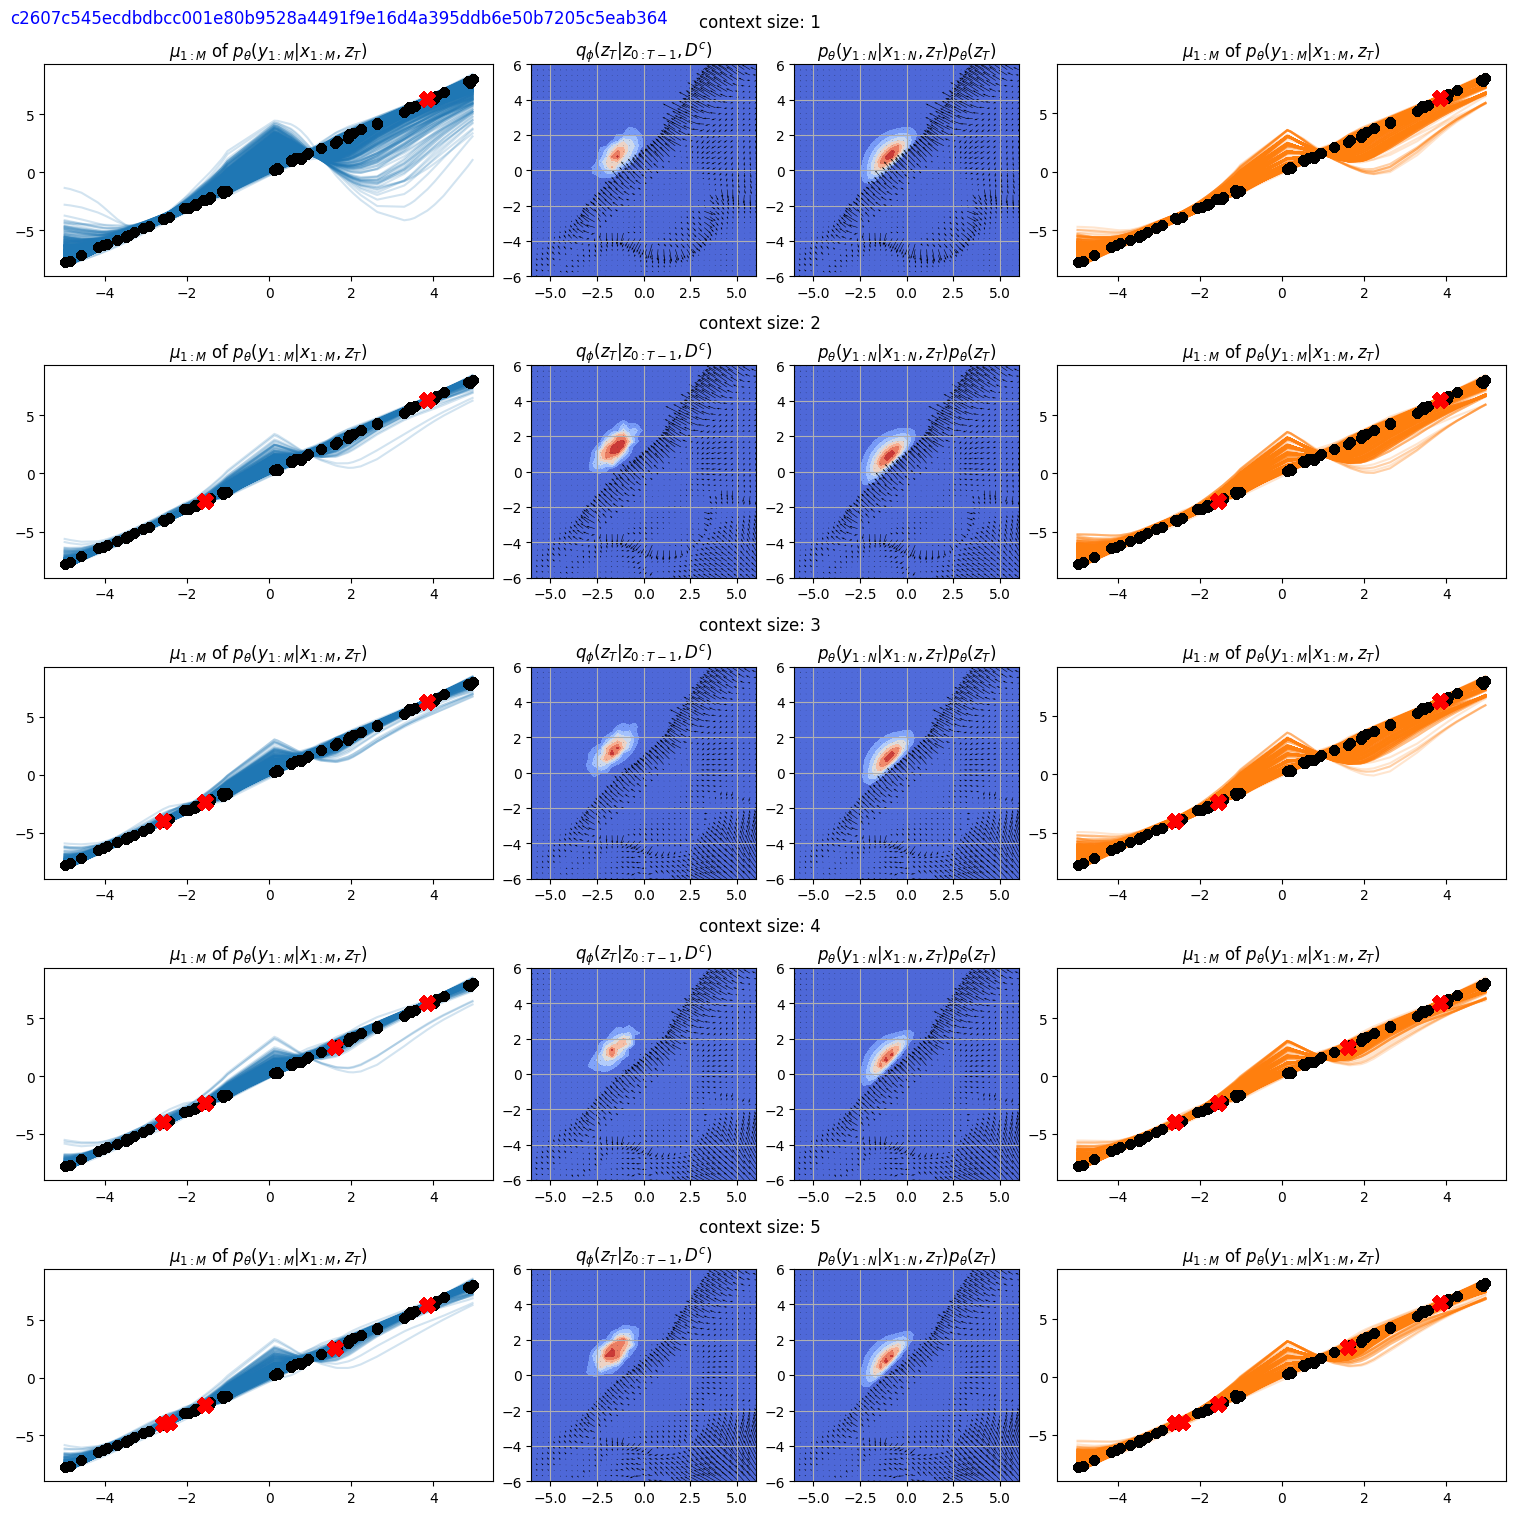

In [17]:
max_context_size = 5
num_samples = 1600  # num_cells will be root

ranges = [(-6, 6), (-6, 6)]

targets, samples = visualize_dvinp(
    device=device,
    dvinp=model,
    dataloader=test_loader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)

In [30]:
from dviforbml.components.cdvi.cmcd import CMCD
from dviforbml.components.cdvi.ula import ULA
from dviforbml.components.control.aggr_control import AggrControl
from dviforbml.components.schedule.annealing_schedule import AggrAnnealingSchedule
from dviforbml.components.schedule.free_noise_schedule import AggrFreeNoiseSchedule

annealing_schedule = AggrAnnealingSchedule(
    z_dim=cfg.model.z_dim,
    h_dim=cfg.model.h_dim,
    non_linearity=cfg.model.non_linearity,
    num_steps=cfg.model.num_steps,
    max_context_size=cfg.model.max_context_size,
    device=device,
)

noise_schedule = AggrFreeNoiseSchedule(
    z_dim=cfg.model.z_dim,
    h_dim=cfg.model.h_dim,
    num_steps=cfg.model.num_steps,
    num_layers=cfg.model.num_layers_sched,
    non_linearity=cfg.model.non_linearity,
    max_context_size=cfg.model.max_context_size,
    device=device,
)

control = AggrControl(
    h_dim=cfg.model.h_dim,
    z_dim=cfg.model.z_dim,
    num_steps=cfg.model.num_steps,
    num_layers=cfg.model.num_layers_ctrl,
    non_linearity=cfg.model.non_linearity,
    max_context_size=cfg.model.max_context_size,
    use_score=False,
)

model.cdvi = CMCD(
    z_dim=cfg.model.z_dim,
    num_steps=cfg.model.num_steps,
    control=control,
    step_size_schedule=model.cdvi.step_size_schedule,
    noise_schedule=noise_schedule,
    annealing_schedule=annealing_schedule,
    device=device,
)


model.freeze_decoder()
# model.freeze_encoder()